# Assignment 1 - AI2

__Student's Credentials__: Vissarion Moutafis - sdi1800119

In this assignment we will try to create an effective ML pipeline that will get a raw sentence and will predict whether the sentence is pro-vaccine or anti-vaccine or neutral. The training corpus comes from twitter, as well as the evaluation dataset.

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix, recall_score, log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler


import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

seaborn.set_style("ticks")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing and Feature Extraction

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# CHANGE THIS ONLY
dir_path = "/content/drive/MyDrive/Collab-Datasets/Vaccine Sentiment Dataset/"


In [6]:
train_dt_path = dir_path + "vs_train.csv"
test_dt_path = dir_path + "vs_dev.csv"

LABELS = ['neutral', 'anti-vax', 'pro-vax']

In [7]:
train_df_raw = pd.read_csv(train_dt_path, index_col=0)
test_df_raw = pd.read_csv(test_dt_path, index_col=0)

train_df_raw.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [8]:
# get test/test X and y
X_train_raw, y_train = train_df_raw["tweet"].to_numpy().reshape((-1,1)), train_df_raw["label"].to_numpy().reshape((-1,1))
X_test_raw, y_test = test_df_raw["tweet"].to_numpy().reshape((-1,1)), test_df_raw["label"].to_numpy().reshape((-1,1))

### Data Cleaning

Actions Taken to clean sentences:

- All to lower case
- Remove http(s):// since its useless
- Separate URL parts since there might be some hidden features there
- Remove specific stopwords
- Remove punctuation

In [9]:
sw = set([re.sub(r'[^\w\s]', '', w) for w in stopwords.words("english")]) - {"no", "yes", 'dont', 'didnt', 'wasnt', 'wont', 'will', 'not', 'can', 'cannot', 'should', 'shouldnt'}
lemmatizer = WordNetLemmatizer()

In [10]:
def clean_tweet(tweet):
  all_lower_s = str(tweet).lower().strip(' ').strip('\t') # all to lowercase
  no_http_s = re.sub(r'http://|https://', '', all_lower_s) # keep only the part after http(s), for space efficiency 
  no_http_s = re.sub(r'/', ' ', no_http_s) # separate domain from link ending
  no_punctuation_s = re.sub(r'[^\w\s]', '', no_http_s) # remove punctuation
  no_stopwords_s = ' '.join([w for w in no_punctuation_s.split() if not w in sw]) 
    
  return " ".join([lemmatizer.lemmatize(w, pos='v') for w in no_stopwords_s.split()])

def clean_tweets(X):
  return np.apply_along_axis(clean_tweet, 1, X)

In [11]:
# clean the tweets
cleaned_tweets = clean_tweets(X_train_raw)

## Feature Extraction w\ vectorizing

Now it's time to extract features and create a bug of words. For this task we will create a function to return the transformed encoded data so we can actually train the model. We could use 
- CountVectorizer
- HashVectorizer
- TF-IDF Transformer

We will also use a _PCA dimension reducer_ in order to get the most important features of the vector and a _StandardScaler_ to normalize the training instances before model training.

In [12]:
N_FEATURES = 2000         # number of features that the vectorizers will produce
N_FEATS_IMPORTANT = 400   # number of important features to keep after dimension reduction operation
N_GRAMS = (1,3)           # n-grams to consider
MAX_ITER = 500

Define all three vectorizers, the PCA reducer and the Standard Scaler for each one of them

In [13]:
count_vectorizer = CountVectorizer(ngram_range=N_GRAMS, max_features=N_FEATURES, max_df=0.7)
count_vectorizer.fit(cleaned_tweets)

pca_count = PCA(n_components=N_FEATS_IMPORTANT)
pca_count.fit(count_vectorizer.transform(cleaned_tweets).toarray())

scaler_count = StandardScaler()

In [14]:
hash_vectorizer = HashingVectorizer(ngram_range=N_GRAMS, n_features=N_FEATURES)
hash_vectorizer.fit(cleaned_tweets)

pca_hash = PCA(n_components=N_FEATS_IMPORTANT)
pca_hash.fit(hash_vectorizer.transform(cleaned_tweets).toarray())

scaler_hash = StandardScaler()

In [15]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=N_GRAMS, max_features=N_FEATURES, max_df=0.7)
tfidf_vectorizer.fit(cleaned_tweets)

pca_tfidf = PCA(n_components=N_FEATS_IMPORTANT)
pca_tfidf.fit(tfidf_vectorizer.transform(cleaned_tweets).toarray())

scaler_tfidf = StandardScaler()

In [16]:
# simple function to transform tweets into a normalized feature matrix
def transform_tweets(X, vectorizer, reducer, scaler):
  new_X = reducer.transform(vectorizer.transform(X).toarray())
  from sklearn.utils.validation import check_is_fitted
  try:
    check_is_fitted(scaler)
  except:
    scaler.fit(new_X)
    print("Fitted Scaler")

  return scaler.transform(new_X)

## Softmax Regression

Train the softmax regression models for every vectorization method and fit the models according to $X_{train}$ 

In [17]:
model_count = LogisticRegression(n_jobs=-1, verbose=2, max_iter=MAX_ITER)
X_train_count = transform_tweets(cleaned_tweets, count_vectorizer, pca_count, scaler_count)

model_hash = LogisticRegression(n_jobs=-1, verbose=2, max_iter=MAX_ITER)
X_train_hash = transform_tweets(cleaned_tweets, hash_vectorizer, pca_hash, scaler_hash)

model_tfidf = LogisticRegression(n_jobs=-1, verbose=2, max_iter=MAX_ITER)
X_train_tfidf = transform_tweets(cleaned_tweets, tfidf_vectorizer, pca_tfidf, scaler_tfidf)

Fitted Scaler
Fitted Scaler
Fitted Scaler


In [18]:
model_count.fit(X_train_count, y_train.reshape((-1,)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.2s finished


LogisticRegression(max_iter=500, n_jobs=-1, verbose=2)

In [19]:
model_hash.fit(X_train_hash, y_train.reshape((-1,)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished


LogisticRegression(max_iter=500, n_jobs=-1, verbose=2)

In [20]:
model_tfidf.fit(X_train_tfidf, y_train.reshape((-1,)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.3s finished


LogisticRegression(max_iter=500, n_jobs=-1, verbose=2)


## Softmax Evaluation

Print statistics and the learning curve for each one of the models.

In [29]:
def get_stats(model, X, y):
  y_pred = model.predict(X)
  y_pred_proba = model.predict_proba(X)
  return accuracy_score(y, y_pred), precision_score(y, y_pred, labels=[0,1,2], average='weighted'), f1_score(y, y_pred, labels=[0,1,2], average='weighted'), recall_score(y, y_pred, labels=[0,1,2], average='weighted'), log_loss(y, y_pred_proba)

def print_stats(model, X, y):
  acc, pre, f, rec, loss = get_stats(model, X, y)

  print("Accuracy:", acc)
  print("Precision:", pre)
  print("Recall:", rec)
  print("F1-Score:", f)
  print("Cross Entropy Loss:", loss)

In [30]:
X_test_count = transform_tweets(clean_tweets(X_test_raw), count_vectorizer, pca_count, scaler_count)

print("Count Vectorizer Softmax Regression: ")
print_stats(model_count, X_test_count, y_test)

Count Vectorizer Softmax Regression: 
Accuracy: 0.7011393514461
Precision: 0.6976390709256625
Recall: 0.7011393514461
F1-Score: 0.6959506032751609
Cross Entropy Loss: 0.7037916398498153


In [31]:
X_test_hash = transform_tweets(clean_tweets(X_test_raw), hash_vectorizer, pca_hash, scaler_hash)

print("Hash Vectorizer Softmax Regression: ")
print_stats(model_hash, X_test_hash, y_test)

Hash Vectorizer Softmax Regression: 
Accuracy: 0.6621384750219106
Precision: 0.6476140055684465
Recall: 0.6621384750219106
F1-Score: 0.6474593085048818
Cross Entropy Loss: 0.7671371807702219


In [32]:
X_test_tfidf = transform_tweets(clean_tweets(X_test_raw), tfidf_vectorizer, pca_tfidf, scaler_tfidf)

print("TF-IDF Vectorizer Softmax Regression: ")
print_stats(model_tfidf, X_test_tfidf, y_test)

TF-IDF Vectorizer Softmax Regression: 
Accuracy: 0.6906222611744084
Precision: 0.6868714314005369
Recall: 0.6906222611744084
F1-Score: 0.6848275139949715
Cross Entropy Loss: 0.7093321163843052


Check [this guide](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) that we used and changed a little in order to print the learning curve the way we wanted.

**IMPORTANT NOTE**: The learning_curve function uses a cross-validation technique to evaluate the model and print the learning curve. We override this default behaviour by messing with the $cv$ argument and applied our own K-FOLD validation sets in order to evaluate the model only on test-data **given by the instructors**.

In [25]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
    VERBOSE=False
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("F1-Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring='f1_micro'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    if VERBOSE:
      # Plot n_samples vs fit_times
      axes[1].grid()
      axes[1].plot(train_sizes, fit_times_mean, "o-")
      axes[1].fill_between(
          train_sizes,
          fit_times_mean - fit_times_std,
          fit_times_mean + fit_times_std,
          alpha=0.1,
      )
      axes[1].set_xlabel("Training examples")
      axes[1].set_ylabel("fit_times")
      axes[1].set_title("Scalability of the model")

      # Plot fit_time vs score
      axes[2].grid()
      axes[2].plot(fit_times_mean, test_scores_mean, "o-")
      axes[2].fill_between(
          fit_times_mean,
          test_scores_mean - test_scores_std,
          test_scores_mean + test_scores_std,
          alpha=0.1,
      )
      axes[2].set_xlabel("fit_times")
      axes[2].set_ylabel("Score")
      axes[2].set_title("Performance of the model")

    return plt

To use the testing set that the instructors provided us with, we will have to create a $cv$ item instance. We will concatenate all train and test data.

In [26]:
y = np.concatenate((y_train, y_test))

X_count = np.concatenate((X_train_count, X_test_count))
X_hash = np.concatenate((X_train_hash, X_test_hash))
X_tfidf = np.concatenate((X_train_tfidf, X_test_tfidf))


We will also divide the dataset based on k-folding, explicitely splitting train and test data, in order to always evaluate test-accuracy based on the given test data.

**NOTE** We will only  use 1-fold evaluation since we have to validate based on the same test set.

In [27]:
# change this for more K-FOLDS
KFOLDS = 1

# calculate slice sizes for test set
test_slice = X_test_count.shape[0] // KFOLDS

# create the train-test indices for k folds
train_test_iter = []
for fold in range(1, KFOLDS+1):
  train_test_iter.append(
      (
          np.arange(0, X_train_count.shape[0], 1), 
          np.arange(X_train_count.shape[0] + 1 , X_train_count.shape[0] + fold*test_slice, 1)
      )
  )

Use the following cell to print the learning curves. Change VERBOSE:  

- $True$: print score-training size graph with performance and scallability graphs
- $False$: print only score-training size graph


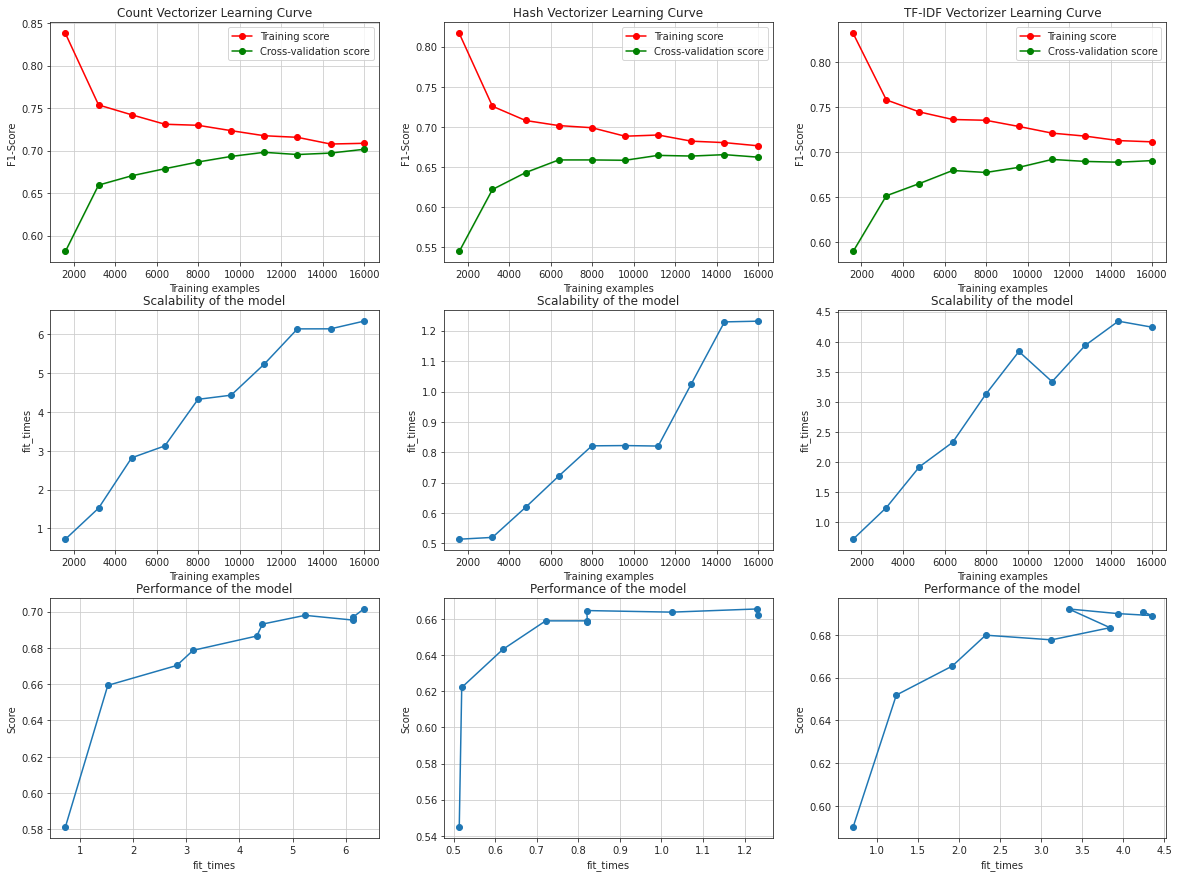

In [28]:
VERBOSE = True

if VERBOSE:
  fig, axes = plt.subplots(3, 3, figsize=(20, 15))
else:
  fig, axes = plt.subplots(1, 3, figsize=(20, 5))
  axes = np.asarray([axes]) # hack to make function work with single axis

plot = plot_learning_curve(LogisticRegression(n_jobs=-1, max_iter=MAX_ITER), "Count Vectorizer Learning Curve", X_count, y, axes=axes[:, 0] , n_jobs=-1, cv=train_test_iter, VERBOSE=VERBOSE)
plot = plot_learning_curve(LogisticRegression(n_jobs=-1, max_iter=MAX_ITER), "Hash Vectorizer Learning Curve", X_hash, y, axes=axes[:, 1] , n_jobs=-1, cv=train_test_iter, VERBOSE=VERBOSE)
plot = plot_learning_curve(LogisticRegression(n_jobs=-1, max_iter=MAX_ITER), "TF-IDF Vectorizer Learning Curve", X_tfidf, y, axes=axes[:, 2] , n_jobs=-1, cv=train_test_iter, VERBOSE=VERBOSE)

## Notes and Observations

We observe that Count Vectorizer and TF-IDF vectorizer work best. We also observe low performance and scalabillity in all models since after the first 4 fits, there is small or no improvement in test-set score, while the more data we provide the model with, the slower it converges, leading to more fits but still, lower scalability over the training dataset size, especially with hashing vectorizer feature extraction process. 

However we already knew that the model estimator is fairly simple (Softmax One-vs-All Regression) and cannot comprehend the complexity of our sentiment analysis problem in order to increase the prediction accuracy and decrease false predictions. The accuracy strictly convergences in values around 70% and that's because our model can only catch linear relations between the features and tweet's sentinment, while the cross entropy error is quite high. 

By observing the learning curves we can watch that the model is as fitted as it could be as the accuracy in test and train instances predictions converges in all 3 models. This means that the bias-variance exhange is fair and there is no overfitting/underfitting. In conclusion, in order to get better predictions we have to add a non-linearity to the model, something that must be done using a different algorithm that sklearn's Logistic Regression.